<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_nonMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [3]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


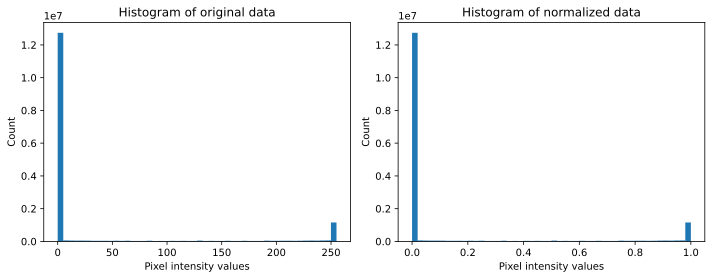

In [7]:
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Create train/TEST GROUPS USING DataLoader

In [8]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
#check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchsize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(1000x400)
labels              ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor           tensor([6, 5, 7,  

Create the DL model

In [11]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax(self.output(x),axis=1)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.NLLLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

In [14]:
#test the model with one batch
net,lossfun,optimizer=createTheMNISTNet()
X,y =next(iter(train_loader))
yHat = net(X)
print(torch.exp(yHat))
loss = lossfun(yhat,y)
print(loss)

tensor([[0.0821, 0.1105, 0.1111, 0.0988, 0.1114, 0.0849, 0.1009, 0.1118, 0.0985,
         0.0900],
        [0.0829, 0.1094, 0.1112, 0.0979, 0.1103, 0.0843, 0.1007, 0.1131, 0.0987,
         0.0917],
        [0.0816, 0.1104, 0.1120, 0.0985, 0.1106, 0.0849, 0.1006, 0.1125, 0.0983,
         0.0903],
        [0.0817, 0.1114, 0.1135, 0.0986, 0.1116, 0.0842, 0.0988, 0.1121, 0.0987,
         0.0895],
        [0.0818, 0.1112, 0.1131, 0.0984, 0.1115, 0.0860, 0.0998, 0.1117, 0.0974,
         0.0891],
        [0.0821, 0.1101, 0.1125, 0.0987, 0.1114, 0.0834, 0.0993, 0.1120, 0.0996,
         0.0907],
        [0.0818, 0.1113, 0.1121, 0.0976, 0.1121, 0.0861, 0.1000, 0.1124, 0.0971,
         0.0895],
        [0.0816, 0.1114, 0.1129, 0.0984, 0.1119, 0.0838, 0.0989, 0.1117, 0.0996,
         0.0899],
        [0.0811, 0.1109, 0.1137, 0.0998, 0.1112, 0.0838, 0.0993, 0.1118, 0.0994,
         0.0891],
        [0.0813, 0.1113, 0.1121, 0.0988, 0.1111, 0.0850, 0.1004, 0.1127, 0.0982,
         0.0890],
        [0

Create a function that trains the model

In [15]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=60
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

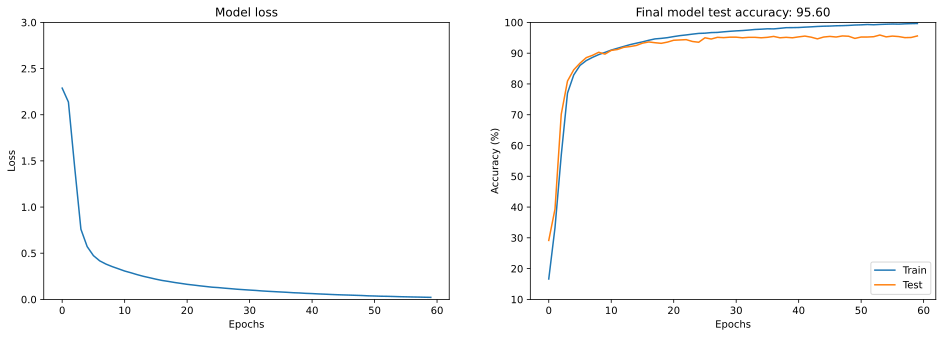

In [17]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

Inspect the results in more detail

In [18]:
X,y=next(iter(test_loader))
predictions=net(X).detach()
predictions

tensor([[-2.3842e-06, -4.1785e+01, -1.3487e+01,  ..., -1.3880e+01,
         -2.3668e+01, -2.1812e+01],
        [-2.1776e-01, -2.7562e+01, -1.0820e+01,  ..., -2.2185e+01,
         -1.6342e+00, -1.4373e+01],
        [-1.5856e+01, -9.9695e+00, -6.5020e+00,  ..., -1.8608e-03,
         -1.2039e+01, -1.1908e+01],
        ...,
        [-8.4920e+00, -4.5881e+00, -9.7934e+00,  ..., -1.4321e+01,
         -2.5484e-02, -1.1512e+01],
        [-2.1020e+01, -1.7943e+01, -2.7359e+01,  ..., -3.8593e+01,
         -1.5146e+01, -2.1368e+01],
        [-2.3548e+01, -3.0451e+01, -3.0816e+01,  ..., -2.4427e+01,
         -1.3335e+01, -1.2825e+01]])

<ipython-input-21-9d383132a6fc>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(range(10),np.exp(predictions[sample2show]))


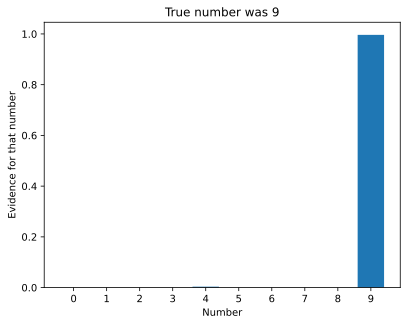

In [21]:
#evidence for all numbers from one sample
sample2show=120
plt.bar(range(10),np.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title("True number was %s"%y[sample2show].item())
plt.show()

[   7   19   34   70  109  135  143  151  160  186  227  234  277  296
  298  395  399  409  422  469  477  501  526  555  556  568  599  613
  652  675  685  724  762  832  839  853  859  867 1016 1034 1048 1059
 1092 1100 1125 1131 1137 1142 1175 1192 1204 1254 1270 1297 1339 1343
 1346 1368 1383 1402 1424 1425 1444 1479 1496 1507 1508 1509 1511 1553
 1563 1584 1591 1609 1630 1635 1642 1685 1713 1764 1838 1843 1860 1862
 1869 1895 1929 1967]


<ipython-input-22-605ba88b614e>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


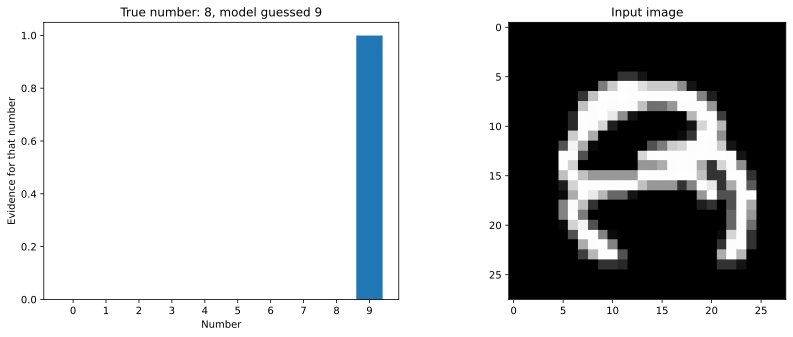

In [22]:
from typing import ChainMap
#find the errors
errors=np.where(torch.argmax(predictions,axis=1)!=y)[0]
print(errors)
#Evidence for all numbers from one sample
sample2show=10
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(),torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show],:],(28,28)),cmap='gray')
ax[1].imshow(X[errors[sample2show]].view(28,28),cmap='gray')
ax[1].set_title('Input image')
plt.show()